In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from ipywidgets import interact
from matplotlib.widgets import Slider
from scipy.signal import find_peaks, argrelextrema
import h5py
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
warn=False

In [2]:
timestamp = pd.Timestamp("12-20-1995 16:56:23")
#timestamp = pd.Timestamp("12-22-1995 13:25:49")
#timestamp = pd.Timestamp("12-22-1995 13:40:13")
#timestamp = pd.Timestamp("12-22-1995 13:57:52")
#timestamp = pd.Timestamp("12-22-1995 14:05:51")
#timestamp = pd.Timestamp("12-22-1995 14:08:28")

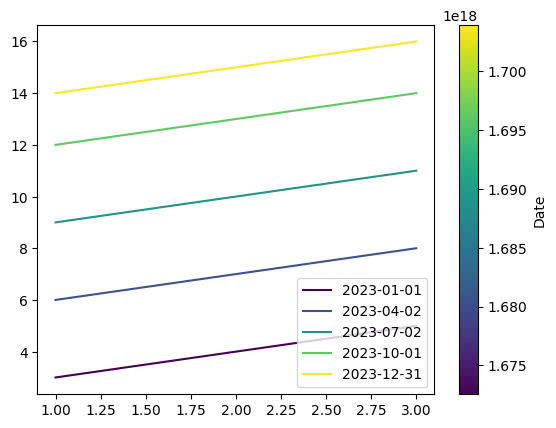

In [3]:
#vlines = [pd.Timestamp("12-20-1995 17:10:40"), pd.Timestamp("12-22-1995 13:25:49"), pd.Timestamp("12-22-1995 13:40:13"), pd.Timestamp("12-22-1995 13:57:52"), pd.Timestamp("12-22-1995 14:05:51"), pd.Timestamp("12-22-1995 14:08:28")]

def in_outbound(df_input):
    df_copy = df_input.copy()
    df_copy[('X_diff [km]')] = df_copy.loc[:,'GSE_X [km]'].diff().interpolate(limit_direction='both')
    point = dir_change_point(df_copy)
    return df_copy[:point[0]] , df_copy[point[1]:]
def dir_change_point(df):
    # gets the point where thevelocity in the gse X direction changes, 
    # showing the change from inbound to outbound
    sign_list = np.sign(df['X_diff [km]'])
    print(sign_list)
    for i in range(len(sign_list)-1):
        if sign_list.iloc[i] * sign_list.iloc[i+1] == -1:
            point = (sign_list.index[i], sign_list.index[i+1])
            break
    return point

def get_full_series(pass_series_input, full_df):
    full_series_output = full_df.loc[pass_series_input.index[0]:pass_series_input.index[-1]]
    return full_series_output

def closest_date(date, series):
    #takes a pd.Timestamp and finds the closest time in the given series
    closest_index = series.index[np.argmin(np.abs(series.index - date))]
    return closest_index
def get_keys(inp):
    #inp = filepath as string
    f = h5py.File(inp, 'r')
    print(list(f.keys()))
    del f

class MplColorHelper:  
    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = mpl.cm.ScalarMappable(norm=self.norm, cmap=self.cmap)  
    def get_rgb(self, val):
        return self.scalarMap.to_rgba(val)

def detect_bfield_rotation(df):
    """
    Detects magnetic field rotations from a DataFrame containing Bx, By, and Bz.
    
    Args:
    df (pd.DataFrame): DataFrame with columns ['Bx', 'By', 'Bz'].
    
    Returns:
    pd.Series: Rotation angles (degrees) between consecutive B-field vectors.
    """
    # Extract B-field components
    B = df[['Bx', 'By', 'Bz']].values

    # Compute vector magnitudes
    B_norm = np.linalg.norm(B, axis=1, keepdims=True)
    
    # Normalize vectors to get direction only
    B_unit = B / B_norm  # Shape (N, 3)
    
    # Compute dot product between consecutive unit vectors
    dot_product = np.einsum('ij,ij->i', B_unit[:-1], B_unit[1:])
    
    # Clip to avoid numerical errors (cosine values must be in [-1, 1])
    dot_product = np.clip(dot_product, -1.0, 1.0)

    # Compute rotation angles in degrees
    theta = np.degrees(np.arccos(dot_product))
    
    # Create a Series with the same index (shifted for alignment)
    return pd.Series(theta, index=df.index[1:], name="Rotation Angle (deg)")

def detect_magnetosheath_edges(df, window_size=50, threshold=5):
    """
    Detects the edges of the magnetosheath using B-field fluctuations.

    Args:
    df (pd.DataFrame): DataFrame with columns ['Bx', 'By', 'Bz']
    window_size (int): Rolling window size for variance computation
    threshold (float): Threshold to detect significant jumps in variance

    Returns:
    edges (list): Indices where the magnetosheath starts and ends
    """
    # Compute B-field magnitude
    df['B_mag'] = np.sqrt(df['Bx']**2 + df['By']**2 + df['Bz']**2)
    
    # Compute rolling standard deviation (measure of turbulence)
    df['B_std'] = df['B_mag'].rolling(window=window_size).std()

    # Detect large changes in variability
    sheath_entry = df['B_std'].idxmax()  # Maximum turbulence indicates entry
    threshold_std = df['B_std'].mean() + threshold * df['B_std'].std()
    possible_exits = df[df['B_std'] < threshold_std].index  # Look for low variability regions

    # Find the first index after the entry where the turbulence settles
    sheath_exit = possible_exits[possible_exits > sheath_entry].min()

    return sheath_entry, sheath_exit

def get_xy(time, df):
    return (df.loc[time]["GSE_X [km]"],df.loc[time]["GSE_Y [km]"])
def closest_date(date, series):
    #takes a pd.Timestamp and finds the closest time in the given series
    closest_index = series.index[np.argmin(np.abs(series.index - date))]
    return closest_index

class DateColorMapper:
    """
    Maps pandas Timestamps to colors within a specified date range using a colormap.
    
    Parameters:
        start_date (pd.Timestamp): Start of the date range.
        end_date (pd.Timestamp): End of the date range.
        cmap (str): Matplotlib colormap name (default: 'viridis').
    """
    def __init__(self, start_date, end_date, cmap='viridis'):
        self.start_date = start_date
        self.end_date = end_date
        self.cmap = plt.get_cmap(cmap)
        self.norm = mcolors.Normalize(
            vmin=self.start_date.value,  # Convert to numerical value (nanoseconds)
            vmax=self.end_date.value
        )

    def __call__(self, date):
        """Returns RGBA color for a given pandas Timestamp."""
        normalized = self.norm(date.value)
        return self.cmap(normalized)

# Example usage
if __name__ == "__main__":
    # Create sample dates
    dates = pd.date_range('2023-01-01', '2023-12-31', periods=5)
    data_x = [1, 2, 3]
    
    # Initialize color mapper
    date_mapper = DateColorMapper(start_date=dates.min(), end_date=dates.max())
    
    # Plot lines with color-mapped dates
    fig, ax = plt.subplots()
    for date in dates:
        # Generate dummy data (replace with your actual data)
        data_y = [date.month + i for i in [2, 3, 4]]
        
        # Get color from date
        line_color = date_mapper(date)
        
        # Plot line with timestamp-based color
        ax.plot(
            data_x, data_y, 
            color=line_color,
            label=date.strftime('%Y-%m-%d')
        )
    
    # Add colorbar
    sm = ScalarMappable(norm=date_mapper.norm, cmap=date_mapper.cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Date')
    
    ax.legend()
 #   plt.show()

In [4]:
df_passes = pd.read_hdf('../datasets/BS_pass.h5', key = 'pass')
f = h5py.File('../datasets/BS_pass.h5', 'r')
f.keys()

<KeysViewHDF5 ['pass']>

In [5]:
merged_df = pd.read_hdf('../datasets/df_merged_for_bs.h5', key = '1995')
merged_df

,n_e,T_c,fit n_e,fit T_c,GSE_R [km],GSE_X [km],GSE_Y [km],GSE_Z [km],GSE_VR [km/s],GSE_VX [km/s],GSE_VY [km/s],GSE_VZ [km/s],v_sw [m/s],n_p [cm^-3],n_a [cm^-3],T_p [eV],B_X [nT],B_Y [nT],B_Z [nT]
1995-01-01 00:00:03.557000000,NaN,NaN,NaN,NaN,662302.083282,482815.289146,-447693.373478,-71442.731034,0.550365,0.646483,-0.101278,-0.098462,NaN,NaN,NaN,NaN,-0.282878,3.307462,-2.430362
1995-01-01 00:00:05.765000000,NaN,NaN,NaN,NaN,662302.332239,482815.581561,-447693.419063,-71442.775612,0.550365,0.646483,-0.101278,-0.098462,NaN,NaN,NaN,NaN,-0.292585,3.248996,-2.562361
1995-01-01 00:00:07.973000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-01 00:00:10.181000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-01 00:00:12.389000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995-12-31 23:51:43.165620224,13.818158,6.1,13.643291,6.185222,579547.547481,558258.870944,-151816.995523,34261.794372,0.033246,0.102451,0.254824,0.022177,424569.15625,7.392810,0.233819,19.527100,0.024329,-2.596262,5.029363
1995-12-31 23:53:13.359933440,13.818158,6.1,13.614986,6.251887,579550.719364,558268.446859,-151793.477947,34263.897401,0.033169,0.102362,0.254827,0.022135,423364.50000,7.276458,0.201343,17.532050,-0.239866,-2.137957,5.379821
1995-12-31 23:54:45.701730304,13.818158,6.1,13.675653,6.154411,579553.891246,558278.022774,-151769.960372,34266.000430,0.033092,0.102273,0.254830,0.022092,422561.28125,7.197524,0.202223,15.644481,0.184208,-1.441417,5.550489
1995-12-31 23:56:18.043527168,13.818158,6.1,13.652801,6.242569,579557.063129,558287.598689,-151746.442796,34268.103460,0.033015,0.102185,0.254833,0.022050,425339.09375,7.445592,0.213474,18.178219,0.211250,-1.125429,5.833228


In [6]:
file_data_95 = '../datasets/QTN_merged_1995.h5'

In [7]:
pass_num = 3
pass_dat = df_passes.query(f'`{'pass'}` == {pass_num}')
inbound, outbound = in_outbound(merged_df[pass_dat.index[0]:pass_dat.index[-1]])

1995-09-14 23:00:01.710   -1.0
1995-09-14 23:00:03.918   -1.0
1995-09-14 23:00:06.126   -1.0
1995-09-14 23:00:08.334   -1.0
1995-09-14 23:00:10.542   -1.0
                          ... 
1995-09-18 13:59:49.940    1.0
1995-09-18 13:59:52.148    1.0
1995-09-18 13:59:54.540    1.0
1995-09-18 13:59:56.748    1.0
1995-09-18 13:59:58.956    1.0
Name: X_diff [km], Length: 142013, dtype: float64


In [8]:
full_pass = merged_df.loc[pass_dat.index[0]:pass_dat.index[-1]]

upstream = merged_df.loc[(pass_dat.index[0]-pd.Timedelta("1 day")):pass_dat.index[0]]

f = h5py.File(file_data_95, 'r')
print(f.keys())
#data_95_11 = pd.read_hdf(file_data_95, key = '9').sort_index()
#data_95_11.columns = ['V2' if 'V2' in col else col for col in data_95_11.columns]
pointx, pointy = get_xy(closest_date(timestamp, merged_df['GSE_X [km]']), merged_df)

<KeysViewHDF5 ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']>


In [9]:
fig = go.Figure(data=go.Scatter(
    x=full_pass["B_X [nT]"].index, 
    y=full_pass["B_X [nT]"].values, 
    mode='lines', 
    name='mag field x', 
    line=dict(width=0.5, color="red"),  # Correct way to set line width
))

fig.add_trace(go.Scatter(
    x=full_pass["B_Y [nT]"].index, 
    y=full_pass["B_Y [nT]"].values, 
    mode='lines', 
    name='mag field y', 
    line=dict(width=0.5, color="green"),
))

fig.add_trace(go.Scatter(
    x=full_pass["B_Z [nT]"].index, 
    y=full_pass["B_Z [nT]"].values, 
    mode='lines', 
    name='mag field z', 
    line=dict(width=0.5, color="blue"),
))
"""
for line in vlines:
    fig.add_shape(
        type="line",
        x0=line, x1=line,  # Vertical line at x=2
        y0=0, y1=1,   # Use 'paper' coordinates (0-1) for full height
        yref="paper",  # Span the entire plot height
        line=dict(color="rgba(0,0,0,0.3)", width=1, dash="dash")
    )
"""
count = len(merged_df.loc[pd.Timestamp("12-20-1995 17:10:35"):pd.Timestamp("12-20-1995 17:40:41")])
fig.update_layout(
    width=1400,
    height=600,
    #dragmode='pan'           # ← make click‑drag pan by default
)

config = {
    'scrollZoom': True,      # ← enable scroll‑wheel zoom
    'displayModeBar': True   # ← show the modebar (zoom/pan icons)
}
print(pass_num)
print(str(timestamp))
print("Vlines:")
for line in vlines:
    print(str(line))

print(count)
fig.show(config=config)

3
1995-12-20 16:56:23
Vlines:


NameError: name 'vlines' is not defined

In [ ]:
x = inbound['GSE_X [km]']
y = inbound['GSE_Y [km]']

plt.figure(figsize=(8, 8))


#valid_mask = ~np.isnan(dx) & ~np.isnan(dy) & ~np.isinf(dx) & ~np.isinf(dy)
#x, y, dx, dy = x[valid_mask], y[valid_mask], dx[valid_mask], dy[valid_mask]

dist, spread, factor = 30, 10, 0.015
x = np.arange(500)-250
y_p = ((-x + dist) / factor)**0.5
y_m = -y_p
dist_in, factor_in = 5, 0.12
y_p_in = ((-x + dist_in) / factor_in)**0.5
y_m_in = -y_p_in

plt.plot(x,y_p, color = 'black', ls = 'dashed')
plt.plot(x,y_m, color = 'black', ls = 'dashed')
plt.plot(x,y_p_in, color = 'black', ls = 'dashed')
plt.plot(x,y_m_in, color = 'black', ls = 'dashed')

plt.scatter(pointx/6371., pointy/6371., color='red', s=100)


plt.xlim(-45, 45)  # Set X-axis limits
plt.ylim(-45, 45)
plt.plot(inbound['GSE_X [km]']/6371., inbound['GSE_Y [km]']/6371., linestyle='-', label='Trajectory', color='black')
plt.plot(outbound['GSE_X [km]']/6371., outbound['GSE_Y [km]']/6371., linestyle='-', label='Trajectory', color='black')
#plt.plot(x/6371., y/6371., marker='.', linestyle='-', label='Trajectory', color='red')
#plt.quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=0.1, color='r', width=0.005, headwidth=6, headlength=8)

COL = MplColorHelper('jet', -3.1415926, 3.1415926)
#scat = plt.scatter(x/6371.,y/6371.,s=20, c=COL.get_rgb(b_phasorxy_df['Angle_rad']), zorder=2)


plt.plot(0,0, 'o', ms=4)
#plt.savefig('filename.png', dpi=1500)
plt.show()

In [ ]:
if str(timestamp) == "1995-12-20 16:56:23":
    td = 20
else:
    td = 60
in_start_zz = str(timestamp - pd.Timedelta(td,'s'))#'1995-11-28 08:53:10'
in_end_zz = str(timestamp + pd.Timedelta(td,'s'))

date_mapper = DateColorMapper(start_date=pd.Timestamp(in_start_zz), 
                            end_date=pd.Timestamp(in_end_zz))
#print(pass_dat.index[0])
#print(closest_date(pd.Timestamp("1995-12-19 20:00:00"), data_95_11['V2']))
#print(data_95_11['V2'].iloc[3])
out_start_zz = '1995-11-29 22:43:00'
out_end_zz = '1995-11-29 22:43:40'

m_e = 9.109e-31
eps_0 = 8.854187817e-12
e_c = 1.602176634e-19

init_f_p_in = pd.DataFrame(columns = ['f_p_hc'], index = data_95_11['V2'][in_start_zz:in_end_zz].index)
init_f_p_out = pd.DataFrame(columns = ['f_p_hc'], index = data_95_11['V2'][out_start_zz:out_end_zz].index)

fig, ax = plt.subplots(1, 2, figsize = (15,7), sharex = True, sharey = True)

freq = np.logspace(np.log10(4e3), np.log10(256e3), 96)
print(freq[0])
count = 0
for index_, row_ in data_95_11['V2'][in_start_zz:in_end_zz].iterrows():
    if count == 0:
        print(row_)
        count += 1
    #print(row_)
    #if index_ in df_QTN[in_start_zz:in_end_zz].dropna().index:
    #    ax.plot(freq, 10.**(row_/10.), label = str(index_)[11:-7])
    if index_ < timestamp:
        color_ = 'blue'
    else:
        color_ = 'red'
    
    ax[0].plot(freq, 10.**(row_/10.), label = str(index_)[11:-7], color =  color_)#date_mapper(index_))
    
    f_p_init_ = freq[row_.reset_index()[(freq>2e4) & (freq<11e4)][row_.name].idxmax()]
    init_f_p_in.loc[row_.name] = f_p_init_
    
    

for index_, row_ in data_95_11['V2'][out_start_zz:out_end_zz].iterrows():
    
    if index_ < pd.Timestamp('1995-11-29 22:43:15'):
        color_ = 'red'
    else:
        color_ = 'blue'
    
    ax[1].plot(freq, 10.**(row_/10.), label = str(index_)[11:-7], color = color_)
    
    f_p_init_ = freq[row_.reset_index()[(freq>3e4) & (freq<6e4)][row_.name].idxmax()]
    init_f_p_out.loc[row_.name] = f_p_init_
    

#plt.scatter(4e3, 7.7268e-12, color='blue', s=100, label="Manual Point")
ax[0].set_title('pass ' )
#ax[1].set_title('pass ' + '4' + '; outbound')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel(r'f [Hz]')
ax[1].set_xlabel(r'f [Hz]')
ax[0].set_ylabel(r'$\mathrm{V^2 [V^2/Hz]}$')
ax[1].set_ylabel(r'$\mathrm{V^2 [V^2/Hz]}$')
ax[0].legend(ncol = 3, fontsize = 5)
ax[1].legend(ncol = 3, fontsize = 9)

init_f_p_in['n_e_hc'] = (init_f_p_in['f_p_hc'] * 2. * np.pi)**2. * m_e * eps_0 / e_c**2. / 1e6
init_f_p_out['n_e_hc'] = (init_f_p_out['f_p_hc'] * 2. * np.pi)**2. * m_e * eps_0 / e_c**2. / 1e6